### Eddy Covariance

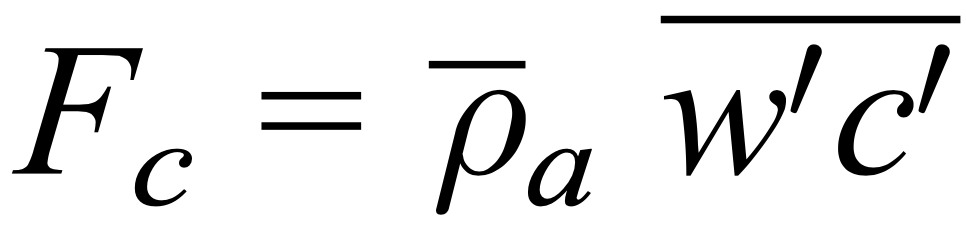

-------

### Webb Correction

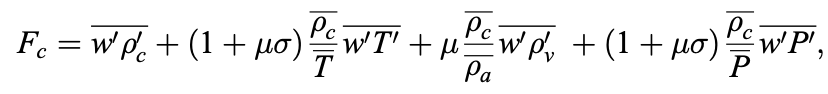

---------
---------
---------

### Import Modules

In [1]:
# Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Function for Eddy Covariance (EC) Technique and WPL Correction

##### Function: Eddy Covariance (EC) Technique and WPL Correction

In [2]:
# Function: Eddy Covariance (EC) Technique and WPL Correction

def calculate_co2_flux(molecular_weight_co2, molecular_weight_water_vapor, molar_density_co2, 
                      molar_density_water_vapor, mixing_ratio_co2, molar_density_co2_i, molar_density_water_vapor_i,
                      R, wi, T, Ti, P, Pi):
    #----------------------------------------------------------------------------------------------------------

    # Calculate molar density of dry air
    Pv = molar_density_water_vapor * R * T # Pa
    Pa = P - Pv # Pa
    molar_density_dry_air = Pa / (R * T) # mol/m^3

    # Calculate molecular weight of dry air
    molecular_weight_dry_air = ((mixing_ratio_co2 / 1e+06) * molecular_weight_co2) * (molar_density_dry_air / molar_density_co2) # kg/mol

    # Calculate µ and sigma
    µ = molecular_weight_dry_air / molecular_weight_water_vapor
    sigma = molar_density_water_vapor / molar_density_dry_air

    #----------------------------------------------------------------------------------------------------------

    # Web correction

    # Second Term
    wi_Ti = wi * Ti
    second_term = (1 + (µ*sigma)) * ((molar_density_co2.mean()) * (wi_Ti.mean()) / (T.mean()))

    # Third Term
    wi_molar_density_water_vapor_i = wi * molar_density_water_vapor_i
    third_term = µ * (molar_density_co2.mean()) * (wi_molar_density_water_vapor_i.mean()) / (molar_density_dry_air.mean())

    # Fourth Term
    wi_Pi = wi * Pi
    fourth_term = (1 + (µ*sigma)) * (molar_density_co2.mean()) * (wi_Pi.mean()) / (P.mean())

    #----------------------------------------------------------------------------------------------------------

    # CO2 Flux (Eddy Covariance)

    FCO2 = molar_density_co2_i * wi # mol/m2s
    co2_flux = (FCO2 * 1e+06).mean() # µmol/m2s

    #----------------------------------------------------------------------------------------------------------

    # CO2 Flux Correction (Eddy Covariance and WPL Correction)

    FCO2_corrected = FCO2 + second_term + third_term + fourth_term # mol/m2s
    FCO2_corrected = FCO2_corrected * 1e+06 # µmol/m2s
    co2_flux_corrected = FCO2_corrected.mean() # µmol/m2s
    
    return co2_flux, co2_flux_corrected

##### Function: Filter

In [3]:
# Function: Filter

def filtered(co2_flux_filtered, co2_flux_corrected_filtered, filter_value):
    
    top_filter_value = filter_value
    bottom_filter_value = filter_value * -1
    
    if co2_flux_filtered > top_filter_value or co2_flux_filtered < bottom_filter_value:
        co2_flux_filtered = np.NaN
        
    if co2_flux_corrected_filtered > top_filter_value or co2_flux_corrected_filtered < bottom_filter_value:
        co2_flux_corrected_filtered = np.NaN
        
    return co2_flux_filtered, co2_flux_corrected_filtered

##### Function: Smoothing

In [4]:
# Function: Smoothing

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

---------
---------
---------

##### Declaring Variables

In [5]:
# Declaring the time range of the data
date = pd.date_range('2015-12-01 00:00:00', '2015-12-02 23:30:00', freq='30T')

# Declaring new variables of "co2_flux" (EC technique) and "co2_flux_corrected" (EC technique and WPL Correction)
co2_flux = np.empty((date.size))
co2_flux_corrected = np.empty((date.size))

# Declaring new variables for filtered CO2 flux: Eliminate CO2 flux above absolute 10 µmol/m2s
co2_flux_filtered = np.empty((date.size))
co2_flux_corrected_filtered = np.empty((date.size))

##### Import Raw Data --- Calculate CO2 Flux by Eddy Covariance Technique and Apply WPL Correction

In [6]:
# Calculate CO2 Flux and Apply WPL Correction

for i in range (0,date.size):
    try:
        day = date[i].strftime('%Y-%m-%d')
        hour = date[i].strftime('%H')
        minute = date[i].strftime('%M')
        second = date[i].strftime('%S')
        read_date = day+'T'+hour+minute+second+'_AIU-1552'

        X = pd.read_csv('Data/Raw Data/'+read_date+'/'+read_date+'.data', sep="\t", skiprows=7)

        #----------------------------------------------------------------------------------------------------------

        # Variables
        molecular_weight_co2 = ((X['CO2 (mg/m^3)']) / (X['CO2 (mmol/m^3)'])) / 1000 # kg/mol
        molecular_weight_water_vapor = ((X['H2O (g/m^3)']) / (X['H2O (mmol/m^3)']/1000)) / 1000 # kg/mol

        molar_density_co2 = (X['CO2 (mmol/m^3)']/1000) # mol/m^3
        molar_density_water_vapor = (X['H2O (mmol/m^3)']/1000) # mol/m^3
        mixing_ratio_co2 = (X['CO2 (umol/mol)']) # µmol/mol

        molar_density_co2_i = ((X['CO2 (mmol/m^3)']/1000) - ((X['CO2 (mmol/m^3)'].mean())/1000)) # mol/m^3
        molar_density_water_vapor_i = ((X['H2O (mmol/m^3)']/1000) - ((X['H2O (mmol/m^3)'].mean())/1000)) # mol/m^3

        R = 8.3145 # J / mol K

        wi = (X['Aux 3 - W (m/s)'] - X['Aux 3 - W (m/s)'].mean())

        T = (X['Temperature (C)'] + 273.15) # K
        Ti = ((X['Temperature (C)'] + 273.15) - ((X['Temperature (C)'].mean()) + 273.15)) # K

        P = (X['Pressure (kPa)'] * 1000) # Pa
        Pi = ((X['Pressure (kPa)']*1000) - ((X['Pressure (kPa)'].mean())*1000)) # Pa
        
        #----------------------------------------------------------------------------------------------------------
        
        co2_flux[i], co2_flux_corrected[i] = calculate_co2_flux(molecular_weight_co2, 
                                                                molecular_weight_water_vapor, 
                                                                molar_density_co2[i], molar_density_water_vapor, 
                                                                mixing_ratio_co2[i], molar_density_co2_i, 
                                                                molar_density_water_vapor_i, R, wi, T, 
                                                                Ti, P, Pi)
        
        co2_flux_filtered[i], co2_flux_corrected_filtered[i] = calculate_co2_flux(molecular_weight_co2, 
                                                                                    molecular_weight_water_vapor, 
                                                                                    molar_density_co2[i], 
                                                                                    molar_density_water_vapor, 
                                                                                    mixing_ratio_co2[i], 
                                                                                    molar_density_co2_i, 
                                                                                    molar_density_water_vapor_i, 
                                                                                    R, wi, T, Ti, P, Pi)
        
    except OSError:
        co2_flux[i] = np.NaN
        co2_flux_corrected[i] = np.NaN
        pass

##### Filter CO2 Flux

In [7]:
# Filter the calculated CO2 Flux

for i in range (0,date.size):    
    co2_flux_filtered[i], co2_flux_corrected_filtered[i] = filtered(co2_flux_filtered[i], co2_flux_corrected_filtered[i], 10)

##### Import CO2 Flux by Eddypro --- Make it into dataframe with other calculated CO2 fluxes

In [8]:
# Read CO2 flux by Eddypro
dataframe = pd.read_excel("Data/MCO-MUKA21_full_output.xlsx", index_col=0, skiprows=[1])
date_dataframe = pd.date_range('2015-11-12 00:30:00', '2020-11-13 00:00:00', freq='30T')
dataframe = dataframe.iloc[:,[13,14,72]][np.where(date_dataframe=='2015-12-01 00:00:00')[0][0]:np.where(date_dataframe=='2015-12-03 00:00:00')[0][0]]
dataframe = dataframe.replace(-9999,np.NaN)

# Put other calculated CO2 fluxes into the same dataframe

dataframe['Uncorrected CO2 Flux'] = co2_flux_filtered
dataframe['Corrected CO2 Flux'] = co2_flux_corrected_filtered

##### Filter all CO2 fluxes based on QC, flux magnitude, and wind direction

In [9]:
# Eliminate QC = 2
# Eliminate Wind Direction that does not come from the sea

for i in range(0,date.size):
    if dataframe['FCO2_QC'][i] == 2.0:
        dataframe.iloc[[i],:] = np.NaN
    
    if dataframe['WD'][i] > 45 and dataframe['WD'][i] < 315:
        dataframe.iloc[[i],:] = np.NaN

##### Notes (Variables in Dataframe):
- FCO2 = CO2 Flux by EddyPro Software
- Corrected CO2 Flux = CO2 Flux Corrected by WPL Correction
- Uncorrected CO2 Flux = CO2 Flux Uncorrected by WPL Correction

In [21]:
dataframe.iloc[23]

FCO2                      0.187487
FCO2_QC                   1.000000
WD                      356.990000
Uncorrected CO2 Flux     -0.181006
Corrected CO2 Flux       -0.116016
Name: 2015-12-01 11:30, dtype: float64